## Setup

In [42]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

# from importlib import reload

### define paths to data

In [43]:
curr_dir = os.getcwd()
os.path.abspath(os.path.join(curr_dir,'..','..'))

'/home/jefan/neurosketch'

In [3]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '2_object_evidence_during_drawing'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import analysis_helpers as h
reload(h)
h.data_dir = data_dir
h.path_to_recog = os.path.join(data_dir, 'features/recog')
h.path_to_draw = os.path.join(data_dir, 'features/drawing')
h.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
h.roi_list_recog = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
h.roi_list_recog_formatted = np.array(['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC'])  #,'mOFC'])
roi_list_recog = h.roi_list_recog

### get file list

In [4]:
## get raw file list for recognition runs
path_to_recog = h.path_to_recog

RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] != 'Draw')])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] != 'Draw')])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [5]:
## get raw file list for drawing runs
path_to_draw = h.path_to_draw

DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] == 'Draw')])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] == 'Draw')])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [6]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#print('Number of subs: {}'.format(len(sub_list)))

In [7]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [8]:
print 'We have data from {} subjects.'.format(len(sub_list))

We have data from 31 subjects.


### How well do we do at classifying the target when we train on recognition patterns only?

#### generate ALLDM supersubject matrix with classifier probabilities

In [9]:
from IPython.display import clear_output
reload(h)
logged = [True,False]
versions = ['2way','3way','4wayIndependent','4way']

really_run = 0
if really_run:
    for l in logged:
        clear_output(wait=True)
        if l==True:
            tag = 'logged'
        elif l==False:
            tag = 'raw'
        for version in versions:
            ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,version=version,logged=l)
            ALLDM.to_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)),index=False) ## train recog, test drawing run    

#### basic summary plot of classifier accuracy between ROIs

In [10]:
really_run = 0
if really_run:
    version = '4way'
    logged = True
    ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,
                                            version=version,logged=logged)
    ## save out Acc
    np.save(os.path.join(results_dir,'decoding_object_accuracy_production.csv'),Acc)

Now analyzing hipp ...


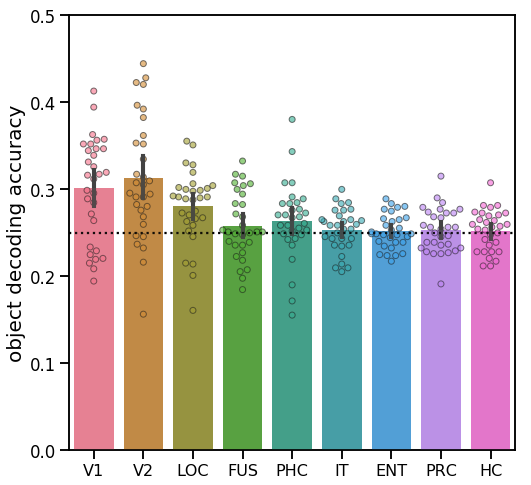

In [41]:
## plot test accuracy on drawing runs; trained on recognition runs
from matplotlib import rc
hfont = {'fontname':'Helvetica'}
if 'Acc' not in locals():
    Acc = np.load(os.path.join(results_dir,'decoding_object_accuracy_production.csv'))

Acc = np.array(Acc)
x = pd.DataFrame(Acc.transpose())
x.columns = roi_list_recog    
sns.set_context('talk')
fig = plt.figure(figsize=(8,8))
fig = sns.barplot(data=x,palette='husl',ci=95,zorder=1)
x2 = x
plt.ylim(0,0.5)

## melt into longform dataframe to be able to make stripplot for draw decoding accuracy 
## for each subject
x = x.assign(sub=sub_list)
xl = pd.melt(x, 
            id_vars=['sub'], 
            var_name='roi',
            value_vars=roi_list_recog, 
            value_name='draw_acc')        
fig2 = sns.swarmplot(data=xl,x="roi", 
                     y="draw_acc", 
                     #color=(0.25,0.25,0.25),
                     palette='husl',
                     dodge=True,
#                      jitter=0.12,
                     alpha=0.6,    
                     size=6,
                     edgecolor=(0.1,0.1,0.1),
                     linewidth=1,
                     zorder=2)    

fig3 = sns.barplot(data=x2,palette='husl',ci=95,alpha=0.1,zorder=3)
plt.xlabel('')

chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
plt.axhline(chance_dict[version],linestyle=':',color='k')
plt.ylabel('object decoding accuracy',fontsize=20, **hfont)
#     plt.title('generalization to drawing phase', **hfont)
fig.set_xticklabels(h.roi_list_recog_formatted,fontsize=16, **hfont)
out_path = os.path.join(proj_dir,'plots/{}/draw_decoding_accuracy.pdf'.format(nb_name))
plt.savefig(out_path,format='pdf')

### make summary timecourse plots

In [77]:
reload(h)
# versions = ['2way','3way','4way', '4wayIndependent']
versions = ['4way']
tags = ['logged']
# tags = ['logged', 'raw']
csvname = 'logistic_timeseries_drawing_neural_{}_{}.csv'

reallyRun = 1
if reallyRun:
    for version in versions:
        for tag in tags:
            ALLDM = pd.read_csv(
                os.path.join(results_dir, csvname.format(version,tag)))
            try:
                h.plot_summary_timecourse(ALLDM,
                                        this_iv='trial_num',
                                        roi_list=roi_list_recog,
                                        render_cond=1,
                                        version = version,
                                        proj_dir=proj_dir)
            except KeyError:
                pass

Now plotting results for V1 ...
Now plotting results for V2 ...
Now plotting results for LOC ...
Now plotting results for IT ...
Now plotting results for fusiform ...
Now plotting results for parahippo ...
Now plotting results for PRC ...
Now plotting results for ento ...
Now plotting results for hipp ...


Now plotting results for V1 ...


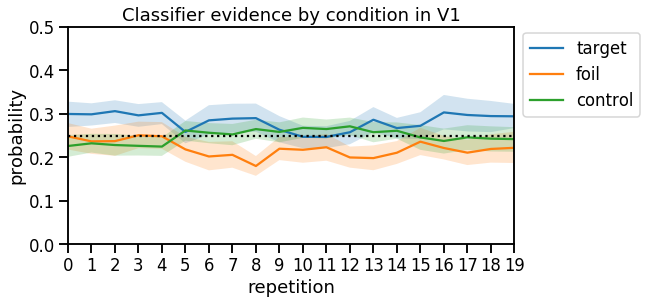

In [75]:
this_iv='trial_num'
roi_list=roi_list_recog
render_cond=1
version = version
proj_dir=proj_dir
baseline_correct = False

subs = np.unique(ALLDM.subj.values)
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))

def flatten(x):
    return [item for sublist in x for item in sublist]

ivs=['run_num','trial_num','time_point']
assert this_iv in ivs    
sns.set_context('talk')
for this_roi in roi_list[:1]:

    print('Now plotting results for {} ...'.format(this_roi))

    T = []
    F = []
    C = []
    Sub = []
    for sub in subs:
        inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) if this_roi != 'VGG' else (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) & (ALLDM['time_point'] == 23)
        t,f,c = h.get_prob_timecourse(this_iv,ALLDM[inds],version=version)
        if baseline_correct:
            t = t - t[0]
            f = f - f[0]
            c = c - c[0]
        if len(T)==0:
            T = t
            F = f
            C = c
            DTF = t-f  ## these differences already in log space       
            DTC = t-c
            DFC = f-c
        else:
            T = np.hstack((T,t))
            F = np.hstack((F,f))        
            C = np.hstack((C,c)) 
            DTF = np.hstack((DTF,t-f))                
            DTC = np.hstack((DTC,t-c))
            DFC = np.hstack((DFC,f-c))
        Sub.append([sub]*len(t))   

    if render_cond==1:
        ## make longform version of dataframe to use in tsplot (by condition)            
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['target','foil','control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((T,F,C))
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        toop = 'condition'            
    else:
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']        
        toop = 'difference'
    #print(x)        
    fig = plt.figure(figsize=(8,4))              
    ## plot it
    sns.tsplot(data=x,
              time=lookup[this_iv],
              unit='sub',
              condition='condition',
              value='probability',
              ci=95)
    if render_cond==1:
        plt.ylim(0,0.5)
        plt.axhline(0.25,linestyle=':',color='k')  
        plt.legend(bbox_to_anchor=(1.3, 1.01))  
        plt.title('Classifier evidence by condition in {}'.format(this_roi))

    else:
        plt.ylim(-0.3,0.3)
        plt.axhline(0,linestyle=':',color='k')  
        plt.legend(bbox_to_anchor=(0.7, 1.01))                        
        plt.title('Difference in classifier evidence by condition in {}'.format(this_roi))             
    plt.xticks(np.arange(np.max(x[lookup[this_iv]].values)+1))
    if not os.path.exists(os.path.join(proj_dir,'plots/{}/{}/{}'.format(nb_name,lookup[this_iv],toop))):
        os.makedirs(os.path.join(proj_dir,'plots/{}/{}/{}'.format(nb_name,lookup[this_iv],toop)))
    plt.tight_layout(rect=[0, 0, 1, 0.5])       
    plt.savefig(os.path.join(proj_dir,'plots/{}/{}/{}/prob_timecourse_{}_by_{}_{}.pdf'.\
                format(nb_name,lookup[this_iv],toop,this_roi,lookup[this_iv],version)))
#     plt.close(fig)


In [61]:
x['probability'] = pd.to_numeric(x['probability'])

In [13]:
vgg_mode = 0
if vgg_mode:
    vgg_tag = 'raw'
    baseline_correct = True
    bc = 'basecorr' if baseline_correct else ''
    VGG = pd.read_csv(str(results_dir)+'VGG_{}_{}.csv'.format(vgg_tag, bc))

    h.plot_summary_timecourse(VGG,
                            this_iv='trial_num',
                            roi_list=['VGG'],
                            render_cond=1,
                            baseline_correct = True,
                            version = version,
                            proj_dir=proj_dir)

#### get subject-level index of contrast between objects during drawing


In [14]:
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version_list = ['2way','3way','4way']
tag = 'logged'
this_iv = 'trial_num' ## other options 'run_num','trial_num','time_point'
reload(h)
for this_version in version_list:
    print '====== {} ======'.format(this_version)
    ALLDM = pd.read_csv('{}/csv/logistic_timeseries_drawing_neural_{}_{}.csv'.format(proj_dir,this_version,tag))
    ALLDM = h.cleanup_df(ALLDM)
    d = h.get_log_odds(ALLDM,
                   this_iv = this_iv,
                   roi_list = roi_list_recog,
                   version=this_version,
                   logged=True,
                   proj_dir=proj_dir)


====== 2way ======
roi
IT           1.001481
LOC          1.361035
PRC          1.004260
V1           1.955847
V2           2.084606
ento         1.014664
fusiform     1.142145
hipp         1.016138
parahippo    1.000927
Name: target-foil, dtype: float64
====== 3way ======
roi
IT           0.999349
LOC          1.417831
PRC          1.002893
V1           2.250851
V2           2.540084
ento         1.028581
fusiform     1.170481
hipp         1.019760
parahippo    0.992483
Name: target-foil, dtype: float64
====== 4way ======
roi
IT           1.006930
LOC          1.437330
PRC          0.999914
V1           2.533271
V2           3.097584
ento         1.020229
fusiform     1.198620
hipp         1.026323
parahippo    0.986918
Name: target-foil, dtype: float64


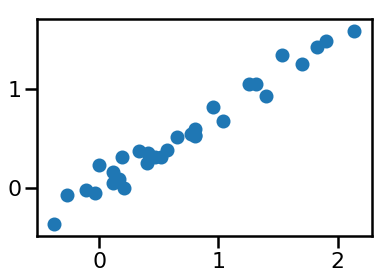

In [15]:
run_this = 1
if run_this:
    ## comparing 4-way and 2-way probability ratios
    d4way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_4way.csv'))
    d2way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_2way.csv'))
    inds = d4way['roi']=='V1'
    plt.scatter(d4way[inds]['target-foil'],d2way[inds]['target-foil'])

In [16]:
conditions = ['target-foil','target-control','foil-control']
for condition in conditions:
    print('------- condition: {} -------'.format(condition))
    for this_roi in roi_list_recog:
        data = d[d['roi']==this_roi][condition].values
        U,lb,ub,p1,p2 = h.bootstrapCI(data,3000)
        print('ROI = {} | mean = {}  95% CI: [{} {}] p(x<0)={} p(x>0)={}'.format(
            this_roi,np.round(U,5),np.round(lb,3),np.round(ub,5),np.round(p1,5),np.round(p2,5)))

------- condition: target-foil -------
ROI = V1 | mean = 0.69538  95% CI: [0.472 0.92676] p(x<0)=0.0 p(x>0)=2.0
ROI = V2 | mean = 0.79073  95% CI: [0.544 1.05589] p(x<0)=0.0 p(x>0)=2.0
ROI = LOC | mean = 0.32103  95% CI: [0.227 0.42033] p(x<0)=0.0 p(x>0)=2.0
ROI = IT | mean = -0.01537  95% CI: [-0.088 0.05629] p(x<0)=1.31067 p(x>0)=0.68933
ROI = fusiform | mean = 0.15829  95% CI: [0.081 0.23466] p(x<0)=0.0 p(x>0)=2.0
ROI = parahippo | mean = -0.02608  95% CI: [-0.081 0.0295] p(x<0)=1.63267 p(x>0)=0.36733
ROI = PRC | mean = -0.01341  95% CI: [-0.07 0.04382] p(x<0)=1.37467 p(x>0)=0.62533
ROI = ento | mean = 0.00705  95% CI: [-0.052 0.06451] p(x<0)=0.80867 p(x>0)=1.19133
ROI = hipp | mean = 0.01326  95% CI: [-0.042 0.07028] p(x<0)=0.64067 p(x>0)=1.35933
------- condition: target-control -------
ROI = V1 | mean = 0.247  95% CI: [0.113 0.38657] p(x<0)=0.0 p(x>0)=2.0
ROI = V2 | mean = 0.2912  95% CI: [0.148 0.43988] p(x<0)=0.0 p(x>0)=2.0
ROI = LOC | mean = 0.15865  95% CI: [0.066 0.26207] p(

### How do individual differences in object evidence relate to individual differences in pre-post differentiation across ROIs?

In [17]:
version = '4way'
tag = 'log'
d = pd.read_csv(os.path.join(proj_dir,'csv/difference_{}probs_{}.csv'.format(tag,version)))
prepost = pd.read_csv(os.path.join(proj_dir,'csv/neural_changes_by_surfroi_and_subject_longform.csv'))

In [18]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp']
roi_dict = dict(zip(roi_list,prepost.roi.unique()))

for this_roi in roi_list:
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = (prepost[(prepost['condition']=='difference') & (prepost['roi']==roi_dict[this_roi])]['prepost_diff']).values

    
    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
    if np.round(p,5)<0.05:
        accent = '*'
    else:
        accent = ''
    print('ROI: {} r={}  p={} {}'.format(this_roi,np.round(r,5),np.round(p,5),accent))
    plt.xlabel('drawing: target vs. foil contrast') 
    plt.ylabel('recog: post-pre differentiation')
    if not os.path.exists(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name))):
        os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
    plt.tight_layout()
    plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog/draw_recog_scatter_{}.png'.format(nb_name,this_roi)))
    plt.close(fig)

ROI: V1 r=0.37475  p=0.03779 *
ROI: V2 r=0.46673  p=0.00812 *
ROI: LOC r=-0.01186  p=0.94952 
ROI: IT r=-0.10254  p=0.58306 
ROI: fusiform r=-0.39501  p=0.02786 *
ROI: parahippo r=0.12824  p=0.49176 
ROI: PRC r=-0.32177  p=0.07753 
ROI: ento r=0.08294  p=0.65735 
ROI: hipp r=0.0656  p=0.72586 


### How are individual differences in object evidence related between ROIs? 

In [19]:
### jgunn will add correlation matrices here